In [1]:
import cv2

In [2]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [3]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

In [4]:
import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
%%time 
import ants

CPU times: user 1.3 s, sys: 487 ms, total: 1.79 s
Wall time: 5.45 s


### LOAD DATA

In [6]:
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

In [7]:
ABIDE_data = np.load(dataFnOut)['data']
#ABIDE_data = np.load('/mmfs1/data/aglinska/3d_grassy_mnist/fake_abide.npy')
df = pd.read_csv(dfFnOut)

In [8]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

In [9]:
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

### LOAD NETWORK WEIGHTS

In [10]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [11]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'
#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
fn = 'Feb04_0524_D16B1G100_DTrue'

#fn = os.path.join(fdir,fn)
fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
#fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb26_1330_forPaperFakeAbide'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

### CHECK NETWORKS

In [12]:
sfari_td_batch = SFARI_data[sfari_subs_td,:,:,:][0:15,:,:,:]
sfari_dupl_batch = SFARI_data[sfari_subs_dupl,:,:,:][0:15,:,:,:]
sfari_del_batch = SFARI_data[sfari_subs_del,:,:,:][0:15,:,:,:]

asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

In [13]:
def cvae_predict(im_in,idx=1):
    # 0 for ASD, 1 for TD
    #im_in = [DX_batch,TD_batch][idx]
    _zeros = np.zeros(s_encoder(im_in)[2].shape)

    v = 2
    cvae_sal_vec = np.hstack((_zeros,s_encoder(im_in)[v]))
    cvae_bg_vec = np.hstack((z_encoder(im_in)[v],_zeros))

    if idx==1:
        cvae_full_vec = np.hstack((z_encoder(im_in)[v],s_encoder(im_in)[v]))
    elif idx==0:
        cvae_full_vec = cvae_bg_vec
        
    out = cvae_decoder.predict(cvae_full_vec)
    
    return out[:,:,:,:,0]

Text(0, 0.5, 'MSE')

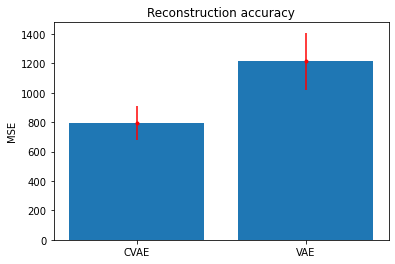

In [14]:
asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
#DX_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

matIn = DX_batch
n = matIn.shape[0]

vae_out = decoder.predict(encoder(matIn)[2])[:,:,:,:,0]
cvae_out = cvae_predict(matIn,idx=1)

vae_resid = (matIn-vae_out)**2
cvae_resid = (matIn-cvae_out)**2

vae_acc = np.array([vae_resid[i,:,:,:].sum() for i in range(n)])
cvae_acc = np.array([cvae_resid[i,:,:,:].sum() for i in range(n)])

xs = [0,1];
m = [cvae_acc.mean(),vae_acc.mean()];
se = [cvae_acc.std(),vae_acc.std()];
plt.bar(xs,m);
plt.errorbar(xs,m,se,fmt='r.');
plt.xticks(xs,labels=['CVAE','VAE']);
plt.title('Reconstruction accuracy')
plt.ylabel('MSE')

### ^VAE is a bit worse at reconstruction overall. This needs to be fixed. For these analyses here it doesnt matter much because the reconstructions are still fairly ok. And also - we're mostly interested in the difference between BG and SL space

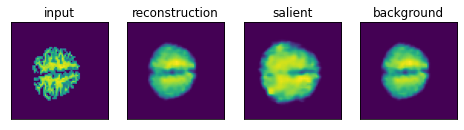

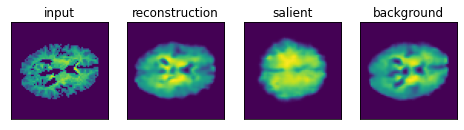

In [15]:
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0) # PLOT ASD SUBJECT
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1) # PLOT TD SUBJECT

### CVAE Reconstructions look good

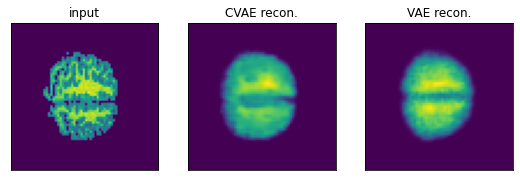

In [16]:
s = 1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1);plt.imshow(matIn[s,:,:,40]);plt.title('input');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,2);plt.imshow(cvae_out[s,:,:,40]);plt.title('CVAE recon.');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,3);plt.imshow(vae_out[s,:,:,40]);plt.title('VAE recon.');plt.xticks([]);plt.yticks([]);

### For CVAE and VAE reconstruct the brain images well

In [17]:
vae_space = dim_reduce(encoder.predict(ABIDE_data)[2])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=2, method='UMAP')

### Distributions of ASD subjects in the three spaces. Evidence of clustering in BG, SL and VAE seem random (RSA results will show how they are organized)

In [18]:
# l = 8
# plt.figure(figsize=(l,l))
# plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder, wspace='z', l=l)
# plt.show()

# plt.figure(figsize=(l,l))
# plot_sweep(ABIDE_data, z_encoder, s_encoder,cvae_decoder,wspace='s', l=l)
# plt.show()


In [19]:
svec = s_encoder.predict(ABIDE_data)

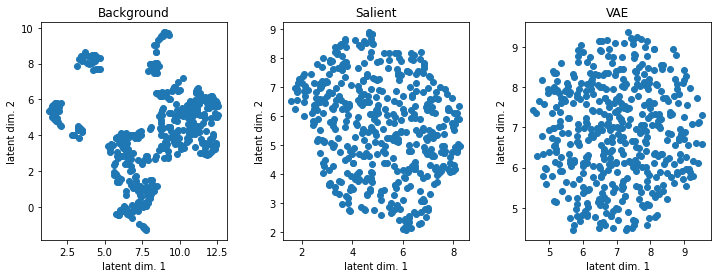

In [20]:
cscatter([bg_space,sl_space,vae_space],v=patients)

In [21]:
%%time
v = patients
rdm_bg = 1-make_RDM(bg_space[v,:],data_scale='ratio')
rdm_sl = 1-make_RDM(sl_space[v,:],data_scale='ratio')
rdm_vae = 1-make_RDM(encoder.predict(ABIDE_data)[2][v,:],data_scale='ratio')

CPU times: user 28.1 s, sys: 3.16 s, total: 31.3 s
Wall time: 1.56 s


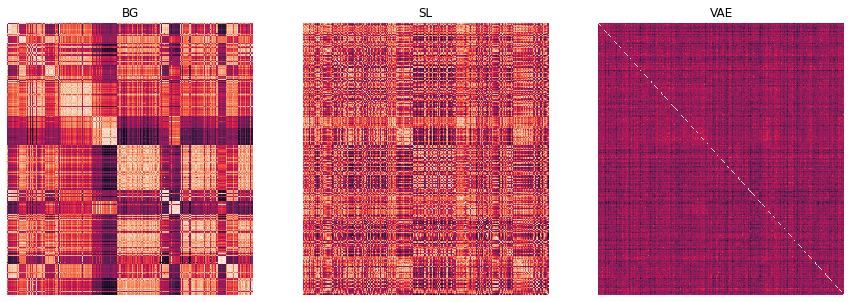

In [22]:
f, ax = plt.subplots(1,3,figsize=(15,5))
sns.heatmap(rdm_bg,cbar=[],ax=ax[0],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_sl,cbar=[],ax=ax[1],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_vae,cbar=[],ax=ax[2],xticklabels=[],yticklabels=[]);

[ax[i].set_title(['BG','SL','VAE'][i]) for i in range(3)];

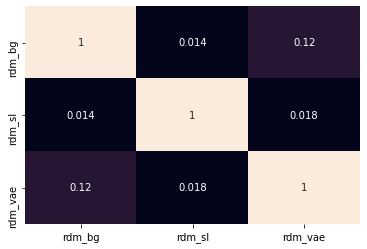

In [23]:
space_cmat = np.corrcoef(np.array([get_triu(x) for x in [rdm_bg,rdm_sl,rdm_vae]]));
lbls= ['rdm_bg','rdm_sl','rdm_vae'];
sns.heatmap(space_cmat,annot=True,cbar=[],xticklabels=lbls,yticklabels=lbls);

In [24]:
from sklearn.mixture import BayesianGaussianMixture

In [25]:
n_clust = 3
bnp = BayesianGaussianMixture(n_components=n_clust,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=1000,
    n_init=10,
    init_params='kmeans',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=None,
    mean_precision_prior=None,
    mean_prior=None,
    degrees_of_freedom_prior=None,
    covariance_prior=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10)

In [26]:
cid_s = bnp.fit_predict(s_encoder.predict(ABIDE_data[patients,:,:,:])[0])
zeros = np.zeros(16)

In [27]:
out = cvae_decoder.predict(np.array([np.hstack((zeros,bnp.means_[i,:])) for i in range(n_clust)]))

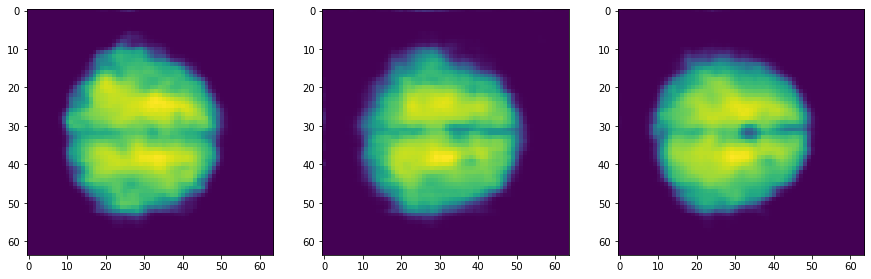

In [28]:
f, ax = plt.subplots(1,n_clust,figsize=(5*n_clust,5))
for i in range(n_clust):
    ax[i].imshow(out[i,:,:,40,:])

In [29]:
from scipy.stats import multivariate_normal
i = 1

In [30]:
mu = bnp.means_[i]
cov = np.linalg.inv(bnp.precisions_[i])

In [31]:
n_sample = 10
sampled_vec = multivariate_normal(mean=mu, cov=cov, allow_singular=False, seed=None).rvs(size=n_sample)
zeros = np.zeros(sampled_vec.shape)
imOut = cvae_decoder.predict(np.hstack((zeros,sampled_vec)))
#plt.imshow(im)

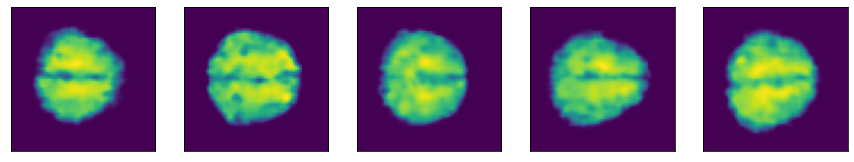

In [32]:
f,ax = plt.subplots(1,5,figsize=(15,5))
[ax[i].imshow(imOut[i,:,:,40,0]) for i in range(5)];
[a.set_xticks([]) for a in ax];
[a.set_yticks([]) for a in ax];

In [33]:
def plot_three(im):
    f,ax = plt.subplots(1,3,figsize=(15,5));
    ii = np.argmax([im[i,:,:].sum() for i in range(im.shape[2])]);
    jj = np.argmax([im[:,i,:].sum() for i in range(im.shape[2])]);
    kk = np.argmax([im[:,:,i].sum() for i in range(im.shape[2])]);

    ax[0].imshow(im[ii,:,:]);
    ax[1].imshow(im[:,jj,:]);
    ax[2].imshow(im[:,:,kk]);

    [a.set_xticks([]) for a in ax];
    [a.set_yticks([]) for a in ax];

In [34]:
data = ABIDE_data[patients,:,:,:]
w = 0
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

(470, 2)


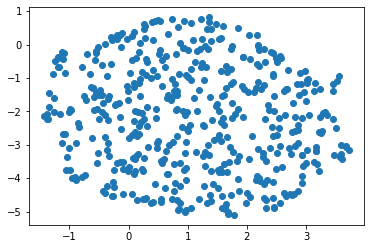

In [35]:
reducer = umap.UMAP(n_components=2)
s_embedding = reducer.fit_transform(space_sl)
plt.scatter(s_embedding[:,0],s_embedding[:,1])
print(s_embedding.shape)

In [36]:
def inverse_tx_umap(targ,s_embedding):
    #targ = [4,11]
    targ = np.array(targ)
    idx = np.argsort(((s_embedding-targ)**2).sum(axis=1))
    #print(idx[0])
    #print(s_embedding[idx[0],:])
    return idx

In [37]:
fn = '/mmfs1/data/aglinska/BC-MRI-AE/Data/anat_temp.nii'
im = ants.image_read(fn)
im = ants.resample_image(image=im,resample_params=(64,64,64),use_voxels=True,interp_type=1)
#im.plot(nslices=5)

In [38]:
def get_brain_pair(b_vec,s_vec):
#     s_vec = space_sl[idx,:]
#     b_vec = space_bg[idx,:]

    vec_asd = np.hstack((b_vec,s_vec))
    vec_td = np.hstack((b_vec,np.zeros(16)))

    im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
    im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]
    
    thresh = 0.1
    im_asd[im_asd<thresh]=0
    im_td[im_td<thresh]=0
    
    nii_asd = im.new_image_like(im_asd)
    nii_td = im.new_image_like(im_td)
    
    return nii_td,nii_asd

In [39]:
def getTxVec(s):
    
    nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
    #tx = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='SyN')
    
    imtx = ants.image_read(os.path.join('/mmfs1/data/aglinska/Tx/',f's{s:04}_BGtoASD.nii.gz'))
    arr = imtx.numpy()
    txVec = np.array([arr[:,:,:,i].flatten().mean() for i in range(3)])
    
    return txVec

In [40]:
# n = space_bg.shape[0]
# txArr = np.array([getTxVec(s) for s in tqdm(range(n))])

In [41]:
template = ants.image_read('/mmfs1/data/aglinska/BC-ASD-FC/Atlas/Atlas_brain_2mm.nii')
template = ants.resample_image(template,(64,64,64),use_voxels=True)

In [42]:
def smooth_brainDif(nii_diff):
    nii_diff = nii_diff.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128)
    #nii_diff[np.abs(nii_diff.numpy())<.01]=0
    #nii_diff = nii_diff.new_image_like(nii_diff.numpy()-np.median(nii_diff.numpy().flatten()))
    #nii_diff = ants.iMath_normalize(nii_diff)
    #nii_diff.plot(nslices=5,crop=True)
    #nii_td.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128).plot(overlay=nii_diff,overlay_alpha=.3,nslices=5,crop=True,axis=0)
    #nii_td.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128).plot(overlay=nii_diff,overlay_alpha=.3,nslices=5,crop=True,axis=1)
    #nii_td.smooth_image(6,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=128).plot(overlay=nii_diff,overlay_alpha=.3,nslices=5,crop=True,axis=2)
    return nii_diff

In [43]:
def get_brain_pair(b_vec,s_vec):

    vec_asd = np.hstack((b_vec,s_vec))
    vec_td = np.hstack((b_vec,np.zeros(16)))

    im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
    im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]
    
    thresh = 0.0
    im_asd[im_asd<thresh]=0
    im_td[im_td<thresh]=0
    
    nii_asd = im.new_image_like(im_asd)
    nii_td = im.new_image_like(im_td)
    
    return nii_td,nii_asd

In [44]:
def norm_brains(anat,template,nii_td,nii_asd,tmp='/scratch/aglinska/'):
    
    
    reg_iterations = (40, 20, 0)
    aff_iterations = (2100, 1200, 1200, 10)
    norm = ants.registration(fixed=template,moving=anat,type_of_transform='SyN',reg_iterations=reg_iterations,aff_iterations=aff_iterations,outprefix=tmp)
    #norm_td = norm['warpedmovout']
    
    norm_asd = ants.apply_transforms(fixed=template,moving=nii_asd,transformlist=norm['fwdtransforms'])
    norm_td = ants.apply_transforms(fixed=template,moving=nii_td,transformlist=norm['fwdtransforms'])
    
    norm_asd.set_origin = template.origin
    norm_td.set_origin = template.origin
    
    return norm_td,norm_asd

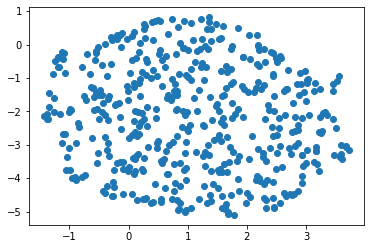

In [45]:
plt.scatter(s_embedding[:,0],s_embedding[:,1]);

In [46]:
def get_umap_corners(s_embedding):
    ax_min = s_embedding.min(axis=0)
    ax_max = s_embedding.max(axis=0)
    ll = inverse_tx_umap((ax_min[0],ax_min[1]),s_embedding)
    lr = inverse_tx_umap((ax_max[0],ax_min[1]),s_embedding)
    tl = inverse_tx_umap((ax_min[0],ax_max[1]),s_embedding)
    tr = inverse_tx_umap((ax_max[0],ax_max[1]),s_embedding)
    cntr = inverse_tx_umap(s_embedding.mean(axis=0),s_embedding)
    
    map_ = dict()
    map_['ll'] = ll
    map_['lr'] = lr
    map_['tr'] = tr
    map_['tl'] = tl
    map_['center'] = cntr

    return map_

In [47]:
def get_diff_norm(corner,i,smooth=False):
    map_ = get_umap_corners(s_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
    anat = im.new_image_like(abide_asd[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    diff = norm_asd-norm_td
    
    if smooth==True:
        diff = diff.smooth_image(sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
    
    return diff

In [48]:
get_diff_norm??

Signature: get_diff_norm(corner, i, smooth=False)
Docstring: <no docstring>
Source:   
def get_diff_norm(corner,i,smooth=False):
    map_ = get_umap_corners(s_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
    anat = im.new_image_like(abide_asd[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    diff = norm_asd-norm_td
    
    if smooth==True:
        diff = diff.smooth_image(sigma=6,sigma_in_physical_coordinates=True,FWHM=True,max_kernel_width=32)
    
    return diff
File:      /mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/<ipython-input-47-67405ad37850>
Type:      function


In [49]:
# for corner in ['ll','lr','tl','tr','center']:
#     sample = [get_diff_norm(corner,i,smooth=False) for i in tqdm(range(25))]
#     e = np.nan
#     group = np.array([arr.numpy() for arr in sample])
#     group[abs(group)<.1] = 0
#     t = group.mean(axis=0)/(group.std(axis=0)/np.sqrt(group.shape[0]))
#     t[np.isinf(t)] = e
#     t[np.isnan(t)]= e
#     t[abs(t)<1.96] = e

#     tmap = norm_td.new_image_like(t)
#     #tmap.plot_ortho(flat=True)
#     template.plot(overlay=tmap,slices=[15,20,32,35,45],axis=0,overlay_alpha=.9,cbar=True,cbar_length=.5,title=corner)
#     template.plot(overlay=tmap,slices=[15,20,32,35,45],axis=1,overlay_alpha=.9)
#     template.plot(overlay=tmap,slices=[15,20,32,35,45],axis=2,overlay_alpha=.9)

In [50]:
def plot_2dvecfield(U,V,ax=None):
    X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
    
    #U  = flow[0:-1:2,0:-1:2,1]
    #V  = flow[0:-1:2,0:-1:2,0]

    if not ax:
        fig, ax = plt.subplots()
        #ax3.set_title("pivot='tip'; scales with x view")

    M = np.hypot(U, V)
    Q = ax.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.022,
                   scale=1/0.15)

    qk = ax.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                       coordinates='figure')
    ax.scatter(X, Y, color='0.5', s=1)
    plt.xticks([]);plt.yticks([])

    #plt.show()

In [51]:
import scipy

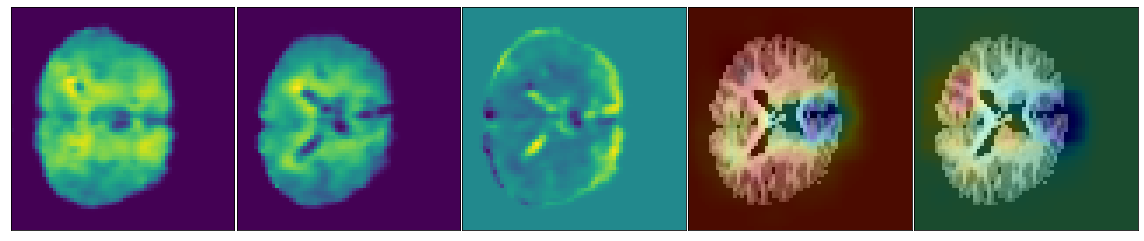

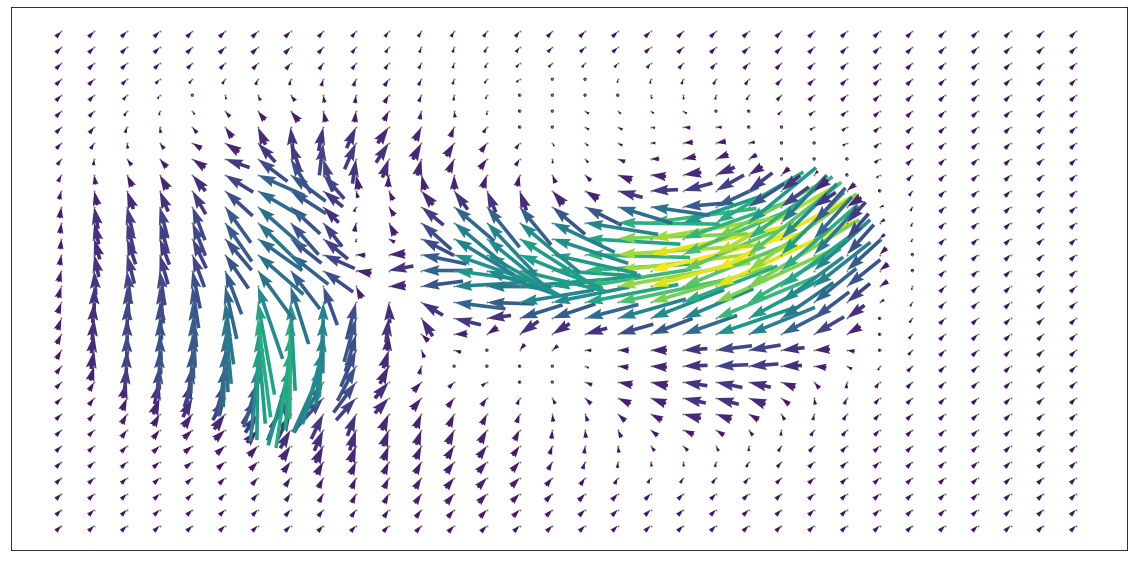

In [52]:
#for i in range(5):

map_ = get_umap_corners(s_embedding)
idx = map_['tr'][0]
s = idx
nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])


# map_ = get_umap_corners(sfari_embedding)
# idx = map_['tl'][5]
# nii_td,nii_asd = get_brain_pair(sfari_space_bg[idx,:], sfari_space_sl[idx,:])
# anat = im.new_image_like(data_sfari[idx,:,:,:])


#norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
#nii_td,nii_asd = norm_td,norm_asd

bg = anat.numpy()
ax = 0
if ax==0:
    j = np.argmax([nii_td.numpy()[:,:,i].sum() for i in range(64)])
    P = nii_td.numpy()[:,:,j]
    N = nii_asd.numpy()[:,:,j]
    anat_slice = bg[:,:,j]
elif ax==1:
    j = np.argmax([nii_td.numpy()[:,i,:].sum() for i in range(64)])
    P = nii_td.numpy()[:,j,:]
    N = nii_asd.numpy()[:,j,:]
    anat_slice = bg[:,j,:]
elif ax==2:
    j = np.argmax([nii_td.numpy()[i,:,:].sum() for i in range(64)])
    P = nii_td.numpy()[j,:,:]
    N = nii_asd.numpy()[j,:,:]
    anat_slice = bg[j,:,:]

#flow = cv2.calcOpticalFlowFarneback(N,P, None, 0.5, 3, 15, 3, 5, 1.2, 0)
flow = cv2.calcOpticalFlowFarneback(P,N, None, 0.5, 3, 15, 3, 5, 1.2, 0)
flow = np.reshape(scipy.stats.zscore(flow.flatten()),flow.shape)
#flow[abs(flow)<1.96] = 0

plt.figure(figsize=(16,10))
plt.subplot(1,5,1)
plt.imshow(P);plt.xticks([]);plt.yticks([])
plt.subplot(1,5,2)
plt.imshow(N);plt.xticks([]);plt.yticks([])

plt.subplot(1,5,3)
plt.imshow(P-N);plt.xticks([]);plt.yticks([])

plt.subplot(1,5,4)
plt.imshow(anat_slice,cmap='gray')
plt.imshow(flow[:,:,0],cmap='jet',alpha=.3);plt.xticks([]);plt.yticks([])

plt.subplot(1,5,5)
plt.imshow(anat_slice,cmap='gray');plt.xticks([]);plt.yticks([])
plt.imshow(flow[:,:,1],cmap='jet',alpha=.3);plt.xticks([]);plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=.01,wspace=.01,top=.5,)

f, ax = plt.subplots(1,1,figsize=(20,10))
U  = flow[0::2,0::2,0]
V  = flow[0::2,0::2,1]
plot_2dvecfield(U,V,ax=ax)

In [53]:
def plot_warp_3d(nii_tx,ax=None):
    # 64,64,64,3
#     %matplotlib inline
#     nii_tx = warp_nii

    targ_size = np.repeat(8,3)
    
    tx_mat = np.array([template.new_image_like(nii_tx.numpy()[:,:,:,i]).resample_image(targ_size,use_voxels=True).numpy() for i in range(3)])
    tx_mat = np.array([scipy.stats.zscore(tx_mat[i,:,:,:].flatten()).reshape(targ_size) for i in range(3)])

    
    
    if not ax:
        fig = plt.figure(figsize=(10,10))
        ax = fig.gca(projection='3d')

    x, y, z = np.meshgrid(np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]))

    u = tx_mat[0,:,:,:]
    v = tx_mat[1,:,:,:]
    w = tx_mat[2,:,:,:]
    #c = np.random.rand(64,64,64,3)
    
    c = np.arctan2(v, u)
    c = (c.ravel() - c.min()) / c.ptp()
    c = np.concatenate((c, np.repeat(c, 2)))
    c = plt.cm.hsv(c)

    
    ax.quiver(x, y, z, u, v, w,length=.5,arrow_length_ratio=0.3,pivot='tail',normalize=False,alpha=.5,colors=c)

In [54]:
def func_get_td_to_asd_warp(corner,i):
    map_ = get_umap_corners(s_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
    anat = im.new_image_like(abide_asd[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    warp = ants.registration(fixed=norm_asd,moving=norm_td,type_of_transform='SyNOnly')
    warp_nii = ants.image_read(warp['fwdtransforms'][0])
    return warp_nii

In [55]:
nrep = 25
ll_list = [func_get_td_to_asd_warp('ll',i).numpy() for i in tqdm(range(nrep))]
lr_list = [func_get_td_to_asd_warp('lr',i).numpy() for i in tqdm(range(nrep))]
tr_list = [func_get_td_to_asd_warp('tr',i).numpy() for i in tqdm(range(nrep))]
tl_list = [func_get_td_to_asd_warp('tl',i).numpy() for i in tqdm(range(nrep))]

100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


In [56]:
map_ = get_umap_corners(s_embedding)
idx = map_['ll'][0]
nii_td,nii_asd = get_brain_pair(space_bg[idx,:], space_sl[idx,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])
norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
warp = ants.registration(fixed=norm_asd,moving=norm_td,type_of_transform='SyNOnly')
warp_nii = ants.image_read(warp['fwdtransforms'][0])

In [57]:
def func_normalize(ll_mat):
    return (ll_mat-ll_mat.flatten().min()) / (ll_mat.flatten().max()-ll_mat.flatten().min())

In [58]:
ll_mat = np.array(ll_list).mean(axis=0)
lr_mat = np.array(lr_list).mean(axis=0)
tr_mat = np.array(tr_list).mean(axis=0)
tl_mat = np.array(tl_list).mean(axis=0)


ll = warp_nii.new_image_like(ll_mat)
lr = warp_nii.new_image_like(lr_mat)
tr = warp_nii.new_image_like(tr_mat)
tl = warp_nii.new_image_like(tl_mat)

Text(0.5, 0.92, 'LR')

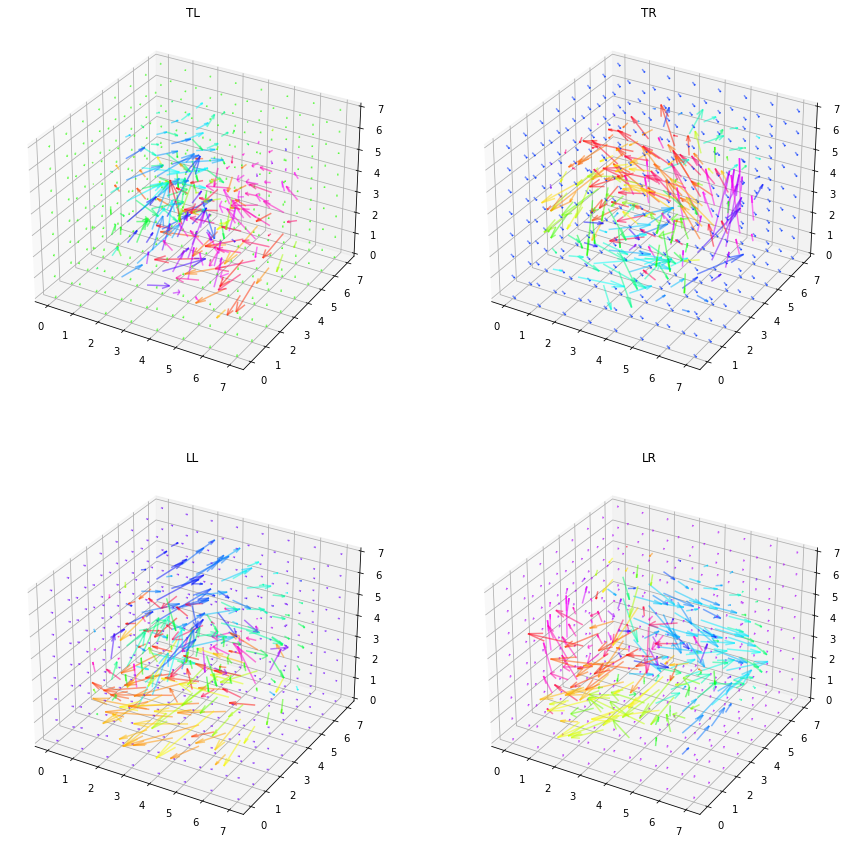

In [59]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
plot_warp_3d(tl,ax=ax)
ax.set_title('TL')

ax = fig.add_subplot(2, 2, 2, projection='3d')
plot_warp_3d(tr,ax=ax)
ax.set_title('TR')

ax = fig.add_subplot(2, 2, 3, projection='3d')
plot_warp_3d(ll,ax=ax)
ax.set_title('LL')

ax = fig.add_subplot(2, 2, 4, projection='3d')
plot_warp_3d(lr,ax=ax)
ax.set_title('LR')

In [60]:
mat_lbl[mat[0]]

NameError: name 'mat_lbl' is not defined

In [ ]:
for mat in enumerate([ll,lr,tl,tr]):
    mat_lbl = ['ll','lr','tl','tr']
    [template.plot(overlay=template.new_image_like(mat[1].numpy()[:,:,:,i]),overlay_alpha=.3,cbar=True,nslices=5,cbar_length=.5,axis=1,title=[mat_lbl[mat[0]],None,None][i]) for i in range(3)];
        
        

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import itertools

x = np.arange(64)
y = np.arange(64)
z = np.arange(64)

# points = []
# for element in itertools.product(x, y, z):
#     points.append(element)

# def f(vals):
#     return np.cos(vals[0]) + np.sin(vals[1]) + vals[2]**0.5

# fxyz = map(f, points)
# xi, yi, zi = zip(*points)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=nii_td.numpy(), alpha=0.5)
plt.show()

In [ ]:
subvec = sfari_subs_del+sfari_subs_dupl
data_sfari = SFARI_data[subvec,:,:,:]

In [ ]:
sfari_space_sl = s_encoder.predict(data_sfari)[2]
sfari_space_bg = z_encoder.predict(data_sfari)[2]
sfari_embedding = reducer.fit_transform(sfari_space_sl)

In [ ]:
plt.scatter(sfari_embedding[:,0],sfari_embedding[:,1],c=dfs['age_months'].values[subvec])

In [ ]:
def func_get_td_to_asd_warp_sfari(corner,i):
    map_ = get_umap_corners(sfari_embedding)
    idx = map_[corner][i]
    nii_td,nii_asd = get_brain_pair(sfari_space_bg[idx,:], sfari_space_sl[idx,:])
    anat = im.new_image_like(data_sfari[idx,:,:,:])
    norm_td,norm_asd = norm_brains(anat, template, nii_td, nii_asd)
    warp = ants.registration(fixed=norm_asd,moving=norm_td,type_of_transform='SyNOnly')
    warp_nii = ants.image_read(warp['fwdtransforms'][0])
    return warp_nii

In [ ]:
nrep = 15
tl_list = [func_get_td_to_asd_warp_sfari('ll',i).numpy() for i in tqdm(range(nrep))]
lr_list = [func_get_td_to_asd_warp_sfari('tr',i).numpy() for i in tqdm(range(nrep))]


tl_mat = np.array(tl_list).mean(axis=0)
lr_mat = np.array(lr_list).mean(axis=0) 

tl = warp_nii.new_image_like(tl_mat)
lr = warp_nii.new_image_like(lr_mat)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
plot_warp_3d(tl,ax=ax)
ax.set_title('TL')

ax = fig.add_subplot(2, 2, 2, projection='3d')
plot_warp_3d(tr,ax=ax)
ax.set_title('TR')


In [ ]:
i = 300
b_vec = space_bg[i,:]
s_vec= space_sl[i,:]
vec_asd = np.hstack((b_vec,s_vec))
vec_td = np.hstack((b_vec,np.zeros(16)))
im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]

In [ ]:
mat1 = abide_asd[i,40,:,:]
mat2 = im_asd[40,:,:]

plt.imshow(mat1)
plt.imshow(mat2,cmap='gray',alpha=.3)

In [ ]:
anat = im.new_image_like(ABIDE_data[i,:,:,:])

In [ ]:
idx = inverse_tx_umap([11,13], s_embedding)
#idx = inverse_tx_umap([5.5,12], s_embedding)
#idx = inverse_tx_umap([8,15], s_embedding)
#idx = inverse_tx_umap([8,10], s_embedding)

idx = idx[20]
s = idx
nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])
anat.plot_ortho(flat=True,overlay=nii_asd,overlay_alpha=.3)
norm_td,norm_asd = norm_brains(anat,template,nii_td, nii_asd)

In [ ]:
idx = inverse_tx_umap([11,13], s_embedding)
#idx = inverse_tx_umap([5.5,12], s_embedding)
#idx = inverse_tx_umap([8,15], s_embedding)
#idx = inverse_tx_umap([8,10], s_embedding)

idx = idx[0]
s = idx
nii_td,nii_asd = get_brain_pair(space_bg[s,:],space_sl[s,:])
anat = im.new_image_like(abide_asd[idx,:,:,:])
#anat.plot_ortho(flat=True,overlay=nii_asd,overlay_alpha=.3)
norm_td,norm_asd1 = norm_brains(anat,template,nii_td, nii_asd)

In [ ]:
# grid = ants.create_warped_grid(
#     image=mi,
#     grid_step=10,
#     grid_width=2,
#     grid_directions=(False, True),
#     fixed_reference_image=fi,
#     transform=tx['fwdtransforms'][0],
#     foreground=1,
#     background=0,
# )

# grid.plot_ortho(flat=True)

# grid.plot(slices=(15,25,35,45),axis=0)
# grid.plot(slices=(25,30,35,45),axis=1)
# grid.plot(slices=(30,35,45,50),axis=2)

In [ ]:
# im.new_image_like(nii_tx.numpy()[:,:,:,0]).plot(nslices=5)
# im.new_image_like(nii_tx.numpy()[:,:,:,1]).plot(nslices=5)
# im.new_image_like(nii_tx.numpy()[:,:,:,2]).plot(nslices=5)

In [ ]:
plt.scatter(s_embedding[:,0],s_embedding[:,1])

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_tx_space(idx):
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:],space_sl[idx,:])

    tx = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='SyN')
    nii_tx = ants.image_read(tx['fwdtransforms'][0])
    
    targ_size = (8,8,8)
    tx_mat = np.array([im.new_image_like(nii_tx.numpy()[:,:,:,i]).resample_image(targ_size,use_voxels=True).numpy() for i in range(3)])

    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')

    x, y, z = np.meshgrid(np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]),
                          np.arange(tx_mat.shape[1]))

    u = tx_mat[0,:,:,:]
    v = tx_mat[1,:,:,:]
    w = tx_mat[2,:,:,:]

    ax.quiver(x, y, z, u, v, w,length=.5,arrow_length_ratio=0.3,pivot='tail',normalize=False)
    ax.set_title(f'S{idx},X:{s_embedding[idx,0]:.2f} Y{s_embedding[idx,1]:.2f}',fontsize=20)
    plt.show()

In [ ]:
# i = 0
# idx0 = inverse_tx_umap([-1.5,9],s_embedding)
# idx1 = inverse_tx_umap([1,13],s_embedding)
# idx2 = inverse_tx_umap([4,11],s_embedding)
# idx3 = inverse_tx_umap([1,8],s_embedding)

# plot_tx_space(idx0[i])
# plot_tx_space(idx1[i])
# plot_tx_space(idx2[i])
# plot_tx_space(idx3[i])

In [ ]:
flow.shape

In [ ]:
U  = flow[0:-1:2,0:-1:2,0]
V  = flow[0:-1:2,0:-1:2,1]

plot_vecfield_2d(U,V)

In [ ]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)

fig3, ax3 = plt.subplots()
ax3.set_title("pivot='tip'; scales with x view")

M = np.hypot(U, V)

Q = ax3.quiver(X, Y, U, V, M, units='x', pivot='tip', width=0.022,
               scale=1 / 0.15)

qk = ax3.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
ax3.scatter(X, Y, color='0.5', s=1)

plt.show()